# 1. SETUP: IMPORT ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Set plot styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

final_output={}

# 2. DATA LOADING

In [2]:
FILE_NAME = '/content/CloudWatch_Traffic_Web_Attack.csv'

try:
    print(f"Loading dataset: {FILE_NAME}...")
    df = pd.read_csv(FILE_NAME)
    print("Dataset loaded successfully.\n")
except FileNotFoundError:
    print(f"---! ERROR !---")
    print(f"File '{FILE_NAME}' not found. Please make sure you have:")
    raise

Loading dataset: /content/CloudWatch_Traffic_Web_Attack.csv...
Dataset loaded successfully.



# 3. INITIAL DATA INSPECTION & CLEANING

In [3]:
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

## 3.1: Data Cleaning & Feature Engineering

In [5]:
# Convert time columns
time_cols = ['creation_time', 'end_time', 'time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Create new feature: 'duration_seconds'
# This is a powerful feature for the EDA
if 'end_time' in df.columns and 'creation_time' in df.columns:
    df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
    # Handle any negative durations (data errors)
    df['duration_seconds'] = df['duration_seconds'].apply(lambda x: x if x >= 0 else 0)

# Fill missing numerical data
num_cols = ['bytes_in', 'bytes_out', 'duration_seconds']
for col in num_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val) #Filled missing numerical columns with their median.

# Fill missing categorical data
cat_cols = ['src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'rule_names']
for col in cat_cols:
    df[col] = df[col].fillna('Unknown') #Filled missing text/categorical columns with 'Unknown'.

# For the model, we MUST treat dst_port as a string/category, not a number
df['dst_port'] = df['dst_port'].astype(str)

# 4. EXPLORATORY DATA ANALYSIS (EDA)

## 4.1. Finding: What are the most common attack types?

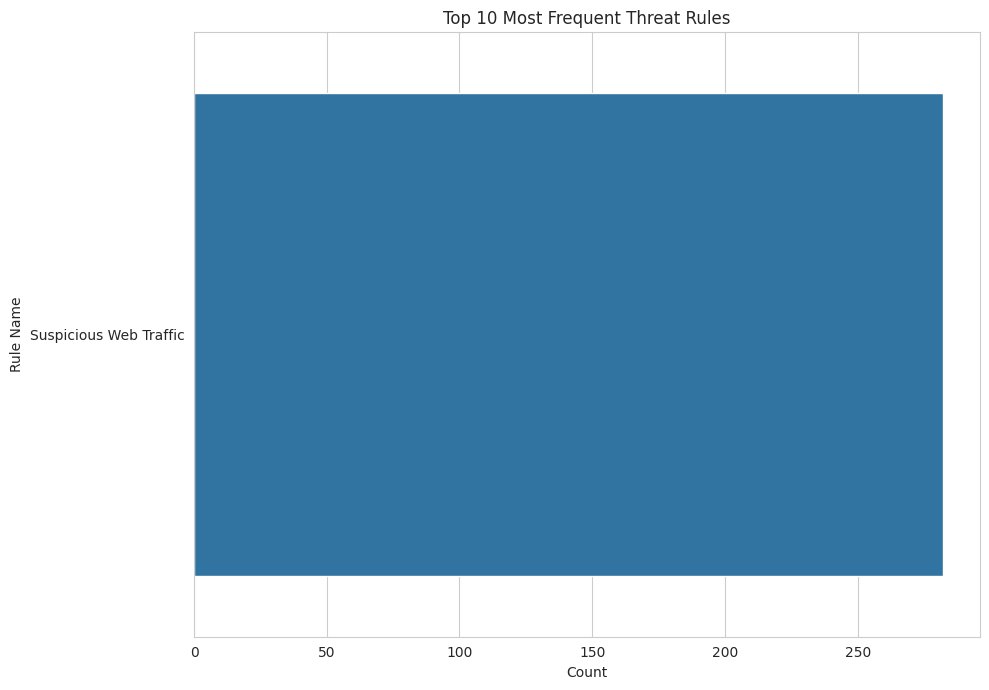

In [6]:
plt.figure(figsize=(10, 7))
top_10_rules = df['rule_names'].value_counts().nlargest(10)
sns.barplot(y=top_10_rules.index, x=top_10_rules.values)
plt.title('Top 10 Most Frequent Threat Rules')
plt.xlabel('Count')
plt.ylabel('Rule Name')
plt.tight_layout()
plt.show()

## 4.2. Finding: Where are the attacks coming from?

In [7]:
country_counts = df['src_ip_country_code'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']
country_counts = country_counts[country_counts['Country'] != 'Unknown']

try:
    fig = px.choropleth(country_counts,
                        locations="Country",
                        locationmode="country names",
                        color="Count",
                        hover_name="Country",
                        color_continuous_scale=px.colors.sequential.YlOrRd,
                        title="Geographical Distribution of Attack Origins")
    fig.show()
except Exception as e:
    print(f"Could not generate map. Error: {e}")

## 4.3. Finding: What services are being targeted?

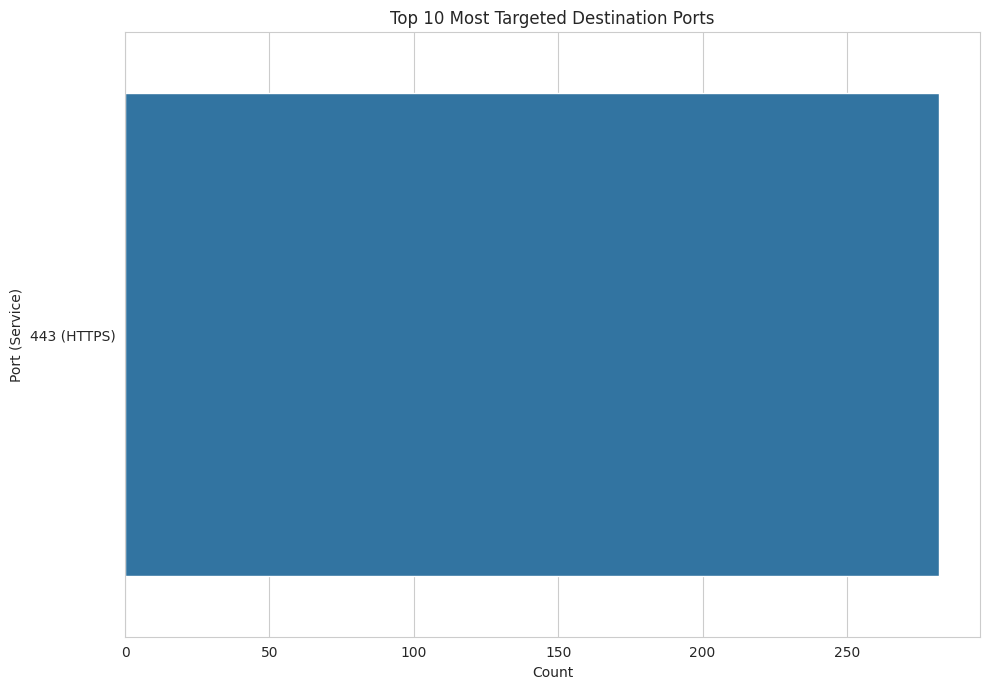

In [8]:
plt.figure(figsize=(10, 7))
top_10_ports = df['dst_port'].value_counts().nlargest(10)

# Create a helper to map common ports to names
def get_port_name(port):
    port_map = {
        '80': '80 (HTTP)', '443': '443 (HTTPS)', '22': '22 (SSH)',
        '3306': '3306 (MySQL)', '1433': '1433 (MSSQL)', '3389': '3389 (RDP)'
    }
    return port_map.get(str(port), str(port))

port_labels = [get_port_name(p) for p in top_10_ports.index]
sns.barplot(y=port_labels, x=top_10_ports.values)
plt.title('Top 10 Most Targeted Destination Ports')
plt.xlabel('Count')
plt.ylabel('Port (Service)')
plt.tight_layout()
plt.show()

## 4.4. Finding: When do these attacks happen?


--- 3.4: Attacks by Hour of the Day ---


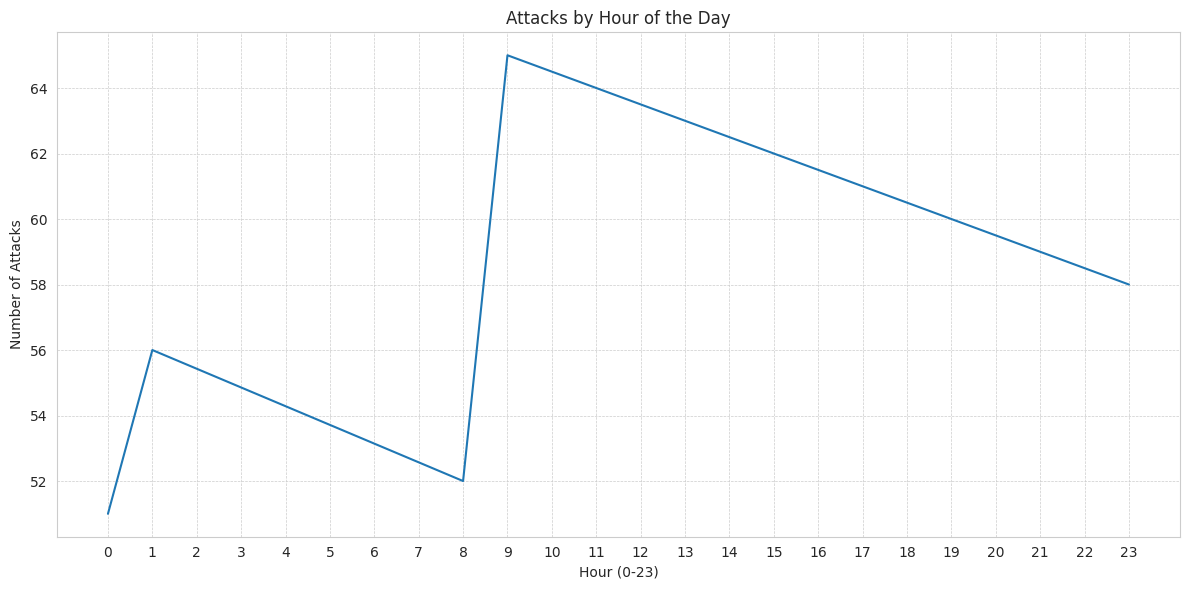

In [9]:
print("\n--- 3.4: Attacks by Hour of the Day ---")
df['hour_of_day'] = df['time'].dt.hour
attacks_by_hour = df.groupby('hour_of_day').size()

plt.figure(figsize=(12, 6))
sns.lineplot(x=attacks_by_hour.index, y=attacks_by_hour.values)
plt.title('Attacks by Hour of the Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Attacks')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## 4.5. Finding: What does an attack "look" like?

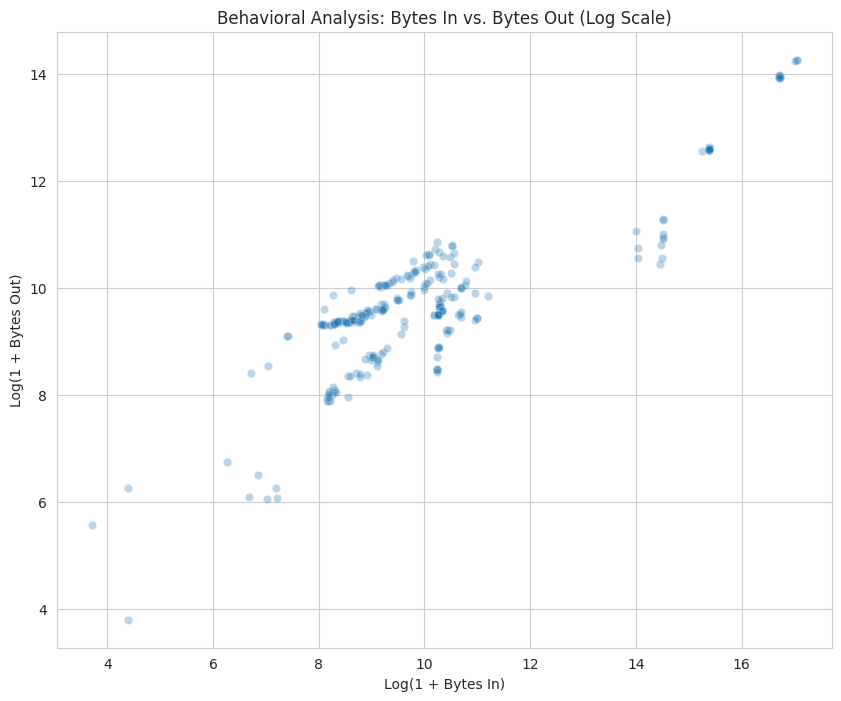

In [10]:
# We use np.log1p (log(1+x)) to handle zero values and scale the data
# This lets us see clusters instead of one big blob at (0,0)
df['log_bytes_in'] = np.log1p(df['bytes_in'])
df['log_bytes_out'] = np.log1p(df['bytes_out'])

plt.figure(figsize=(10, 8))
sns.scatterplot(x='log_bytes_in', y='log_bytes_out', data=df.sample(min(5000, len(df))), alpha=0.3)
plt.title('Behavioral Analysis: Bytes In vs. Bytes Out (Log Scale)')
plt.xlabel('Log(1 + Bytes In)')
plt.ylabel('Log(1 + Bytes Out)')
plt.annotate('Data Exfiltration?\n(Low In, High Out)',
             xy=(2.5, 15), xytext=(3, 18),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', color='red')
plt.annotate('Probing/Scanning?\n(Low In, Low Out)',
             xy=(2.5, 2.5), xytext=(5, 5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')
plt.show()

## 4.6. Finding: How long do attacks last?


--- 3.6: Distribution of Attack Duration ---


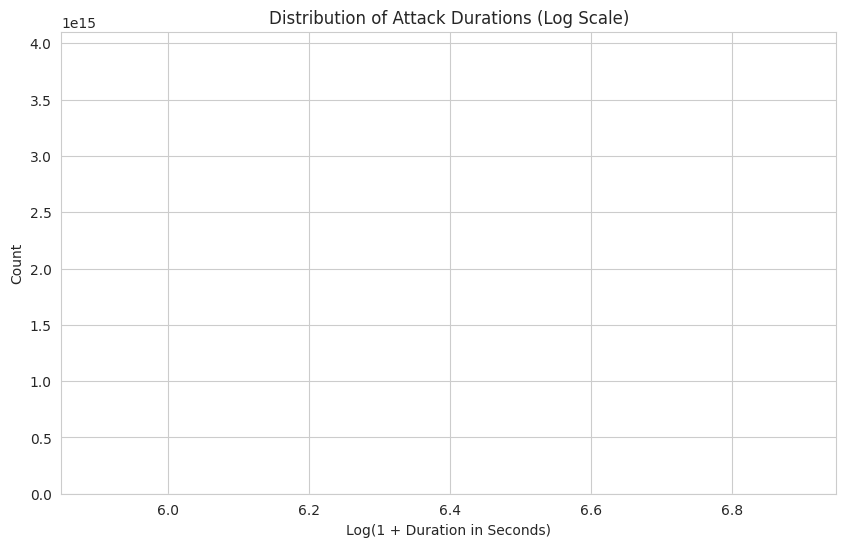

In [11]:
print("\n--- 3.6: Distribution of Attack Duration ---")
# Use log scale again, as durations can vary wildly
df['log_duration'] = np.log1p(df['duration_seconds'])
plt.figure(figsize=(10, 6))
sns.histplot(df['log_duration'], bins=50, kde=True)
plt.title('Distribution of Attack Durations (Log Scale)')
plt.xlabel('Log(1 + Duration in Seconds)')
plt.ylabel('Count')
plt.show()

# 5. ML MODEL TRAINING & EXPORT

## 5.1. Prepare Data for Modeling

In [12]:
# --- Define the Target (y) ---
# Since all rule_names are 'Suspicious Web Traffic', we define priority behaviorally

# Calculate thresholds
bytes_in_threshold = df['bytes_in'].quantile(0.90)
bytes_out_threshold = df['bytes_out'].quantile(0.90)
duration_threshold = df['duration_seconds'].quantile(0.90) if 'duration_seconds' in df.columns else 0

# Define a high-priority event if it exceeds any of the top 10% thresholds
df['is_high_priority'] = df.apply(
    lambda row: 1 if (
        row['bytes_in'] > bytes_in_threshold or
        row['bytes_out'] > bytes_out_threshold or
        (('duration_seconds' in df.columns) and row['duration_seconds'] > duration_threshold)
    ) else 0,
    axis=1
)

# Check distribution
print("\nHigh-priority definition based on top 10% of bytes/duration.")
print(df['is_high_priority'].value_counts(normalize=True))

# --- Define Features (X) ---
features = ['bytes_in', 'bytes_out', 'protocol', 'dst_port']
target = 'is_high_priority'

X = df[features]
y = df[target]

# Safety check
if len(y.unique()) < 2:
    raise ValueError("Still only one class. Consider reducing threshold (e.g., 0.8 quantile).")

print(f"\nCreating model with {len(X)} samples.")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


High-priority definition based on top 10% of bytes/duration.
is_high_priority
0    0.893617
1    0.106383
Name: proportion, dtype: float64

Creating model with 282 samples.


## 5.2. Create a Preprocessing & Modeling Pipeline

In [13]:
numeric_features = ['bytes_in', 'bytes_out']
# 'dst_port' is categorical (we converted it to string)
categorical_features = ['protocol', 'dst_port']

# Create a 'preprocessor' to transform the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # handle_unknown='ignore' is VITAL. It ensures our web app
        # won't crash if it sees a port it wasn't trained on.
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Create the full pipeline: 1. Preprocess, 2. Train Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

## 5.3. Train and Evaluate Model

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Training Complete. Accuracy on Test Set: {accuracy * 100:.2f}%")
print("\nClassification Report (shows how well it finds High Priority threats):")
print(classification_report(y_test, y_pred, target_names=['Low Priority', 'High Priority']))


Model Training Complete. Accuracy on Test Set: 98.25%

Classification Report (shows how well it finds High Priority threats):
               precision    recall  f1-score   support

 Low Priority       0.98      1.00      0.99        51
High Priority       1.00      0.83      0.91         6

     accuracy                           0.98        57
    macro avg       0.99      0.92      0.95        57
 weighted avg       0.98      0.98      0.98        57



# 6. Model Training & Export

In [15]:
# Get the components from the pipeline
preprocessor_fitted = model.named_steps['preprocessor']
classifier_fitted = model.named_steps['classifier']

## 6.1. Get scaling parameters

In [16]:
scaler = preprocessor_fitted.named_transformers_['num']
scaling_params = {
    'mean': list(scaler.mean_),
    'std': list(scaler.scale_)
}

## 6.2. Get one-hot-encoder categories

In [17]:
ohe = preprocessor_fitted.named_transformers_['cat']
categorical_names = ohe.get_feature_names_out(categorical_features)

## 6.3. Get model coefficients

In [18]:
coefficients = classifier_fitted.coef_[0]
intercept = classifier_fitted.intercept_[0]

## 6.4. Combine all feature names and coefficients

In [19]:
# The numeric features always come first
all_feature_names = numeric_features + list(categorical_names)
coef_dict = {name: coef for name, coef in zip(all_feature_names, coefficients)}

## 6.5. Create the final JSON object

In [20]:
model_data = {
    "intercept": intercept,
    "scaling": scaling_params,
    "coefficients": coef_dict
}

## 6.6 Print it as a JSON string

In [21]:
print(json.dumps(model_data, indent=2))
output_filename = 'threat_analysis.json'
with open(output_filename, 'w') as f:
    json.dump(final_output, f, indent=2)

{
  "intercept": -2.6662247412958937,
  "scaling": {
    "mean": [
      1307148.32,
      91303.01777777777
    ],
    "std": [
      4434216.730362863,
      272116.49728576775
    ]
  },
  "coefficients": {
    "bytes_in": 2.7619936490284096,
    "bytes_out": 2.5917415563692074,
    "protocol_HTTPS": -0.0006718284249574006,
    "dst_port_443": -0.0006718284249574006
  }
}
